In [1]:
import sys
import torch
sys.path.append('../')
import nntools.dataset as D
from nntools.dataset.image_tools import normalize, nntools_wrapper

from timm.models.vision_transformer import vit_base_patch32_384
sys.path.append('../../VisionTransformer/extern_packages/Transformer-Explainability')
from baselines.ViT.ViT_LRP import VisionTransformer
from baselines.ViT.ViT_explanation_generator import LRP

import torch.nn.functional as F

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import torch


In [2]:
USE_CUDA = False
FACTOR = 4
GENERATE_HEATMAP = True
PATH_TO_DATASET = '/home/clement/Documents/database/CellData/OCT/test/'
PATH_TO_TRAINED_MODEL = '../../runs/mlruns/1/505896c1301b4f6790efd15dca57b8f9/artifacts/iteration_25000_mIoU_0920.pth'
SAVE_PATH_HEATMAP = 'Explained-ViT-LRP/'
HEATMAP_INTERPOLATION = 'nearest'

In [3]:
trained_savedict = PATH_TO_TRAINED_MODEL

state_dict = torch.load(trained_savedict)
state_dict = state_dict['model_state_dict']
reformated_state_dict = {}
for k in state_dict:
    reformated_state_dict[k.split('network.')[1]] = state_dict[k]

In [4]:
@nntools_wrapper
def to_rgb(image):
    if image.ndim != 3:

        return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        return image

def show_cam_on_image(img, mask, alpha):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap*alpha + (1-alpha)*np.float32(img)
    cam = cam / np.max(cam)
    return cam


def generate_visualization(original_image, class_index=None, alpha=0.5):
    transformer_attribution = attribution_generator.generate_LRP(original_image, method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, int(transformer_attribution.shape[1]**0.5), int(transformer_attribution.shape[1]**0.5))
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, 
                                                              size=original_image.shape[2:], 
                                                              mode=HEATMAP_INTERPOLATION #, align_corners=True
                                                             )
    transformer_attribution = transformer_attribution.data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    
    transformer_attribution = np.squeeze(transformer_attribution)
    image_transformer_attribution = original_image.squeeze(0).permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution, alpha)
    vis =  np.uint8(255 * vis)
#     vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return image_transformer_attribution, vis

In [5]:
if GENERATE_HEATMAP:
    # Create the original ViT + LRP-module (so same model, but with backward hook to compute the LRP)
    model = VisionTransformer(patch_size=32, embed_dim=768, depth=12, 
                              num_heads=12, img_size=384, num_classes=4, qkv_bias=True)
else:
    model = vit_base_patch32_384(num_classes=4)
    # Create the original ViT


composer = D.Composition(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
composer << to_rgb << normalize
dataset = D.ClassificationDataset(PATH_TO_DATASET, shape=[384,384])
dataset.set_composition(composer)


labels = {} 
for k, v in dataset.map_class.items():
    labels[v] = k

model.load_state_dict(reformated_state_dict, strict=True)

factor = FACTOR
def resample_attention(model, factor):
    stride = model.patch_embed.proj.stride
    n_stride = int(stride[0]/factor)
    model.patch_embed.proj.padding = n_stride, n_stride
    model.patch_embed.proj.stride = n_stride, n_stride
    
    
    foo = torch.zeros(1,3,384,384)
    bar = model.patch_embed.proj(foo)
    new_size = bar.shape[2]
    pos_embed = model.pos_embed.transpose(2,1) #BxFxN
    _, f, N = pos_embed.shape
    cls = pos_embed[:,:,0]
    cls = torch.unsqueeze(cls, 2)
    pos_embed = pos_embed[:,:,1:]
    pos_embed = pos_embed.reshape(1, f, int(N**0.5), int(N**0.5))
    pos_embed = F.interpolate(pos_embed, size=(new_size, new_size)).flatten(2)
    pos_embed = torch.cat((cls, pos_embed), 2).transpose(2,1)
    model.pos_embed = torch.nn.Parameter(pos_embed)
    return model

model = resample_attention(model, factor)
if USE_CUDA:
    model = model.cuda()
model.eval()
attribution_generator = LRP(model)


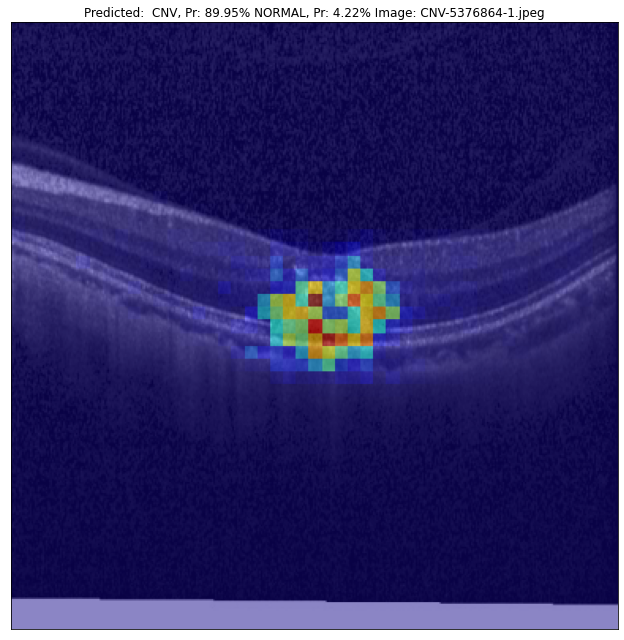

RuntimeError: [enforce fail at CPUAllocator.cpp:65] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 234436800 bytes. Error code 12 (Cannot allocate memory)

In [6]:
preds = []
gts = []
index = np.arange(1000)
np.random.shuffle(index)    

if not os.path.exists(SAVE_PATH_HEATMAP):
    os.makedirs(SAVE_PATH_HEATMAP)

    
def plot():
    """
    Call this fonction to simply plot a heatmap or compute the accuracy of the model
    It will iterate over the whole test set

    """
    for i in index:
        img, gt = dataset[i]
        filename = dataset.filename(i)
        img = img.unsqueeze(0)
        if USE_CUDA:
            img = img.cuda()
        pred = model(img)
        prob = torch.softmax(pred, dim=1)
        pred = torch.argmax(prob, dim=1)
        argsort = torch.argsort(prob, dim=1, descending=True)
        preds.append(pred)
        gts.append(gt)
        if GENERATE_HEATMAP:
            inp, out = generate_visualization(img, pred)
            title = ''
            for arg in argsort.squeeze(0)[:2]:
                title = title + ' ' + labels[int(arg)]+', Pr: {:.2%}'.format((prob[0][arg]))

            fig, ax = plt.subplots()
            ax.grid(False)
            # Hide axes ticks
            ax.set_xticks([])
            ax.set_yticks([])
            fig.set_size_inches(9,9)

            ax.set_title('Predicted: '+ title + ' Image: '+filename)
            ax.imshow(out[:,:,::-1])
            plt.tight_layout()    
       
            plt.show()

def write_map():
    """
    Call this function to write the heatmap in a png.
    It will iterate over the whole test set
    """
    for i in index:
        img, gt = dataset[i]
        filename = dataset.filename(i)
        img = img.unsqueeze(0).cuda()
        pred = model(img)
        prob = torch.softmax(pred, dim=1)
        pred = torch.argmax(prob, dim=1)
        argsort = torch.argsort(prob, dim=1, descending=True)
        preds.append(pred)
        gts.append(gt)    
        inp, out = generate_visualization(img, pred, alpha=1)
        filepath = dataset.img_filepath[i] 
        inp = cv2.imread(filepath)
        
        out = cv2.resize(out, dsize=inp.shape[:2][::-1])
        
        cv2.imwrite(os.path.join(SAVE_PATH_HEATMAP, filename), out)

        
# From here, you can either call plot or write_map        
if GENERATE_HEATMAP:
    plot() 
else:
    with torch.no_grad():        
        plot()


Factor 1: 93.7% (default)
Factor 2: 95.3%
Factor 4: 95.5%
Factor 8: 93.8%